In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import string
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from keras.initializers import Constant
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
data = pd.read_csv('/kaggle/input/us-consumer-finance-complaints/consumer_complaints.csv')
data.head()

/tmp/ipykernel_26/3594088055.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/kaggle/input/us-consumer-finance-complaints/consumer_complaints.csv')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [4]:
miss_col_train = data.isnull().sum()[data.isnull().sum() > 0].sort_values(ascending=True)
percent_miss_train = round((miss_col_train / len(data) * 100) , 2)
missing_train = pd.DataFrame([miss_col_train, percent_miss_train]).T.rename(columns={0:'Feature', 1:'missing'})
missing_train

,Feature,missing
zipcode,4505.0,0.81
state,4887.0,0.88
sub_product,158322.0,28.48
sub_issue,343335.0,61.76
consumer_consent_provided,432499.0,77.79
company_public_response,470833.0,84.69
tags,477998.0,85.98
consumer_complaint_narrative,489151.0,87.98


In [5]:
pd.set_option('max_colwidth', 500)
data[['consumer_complaint_narrative']].head(5)

,consumer_complaint_narrative
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


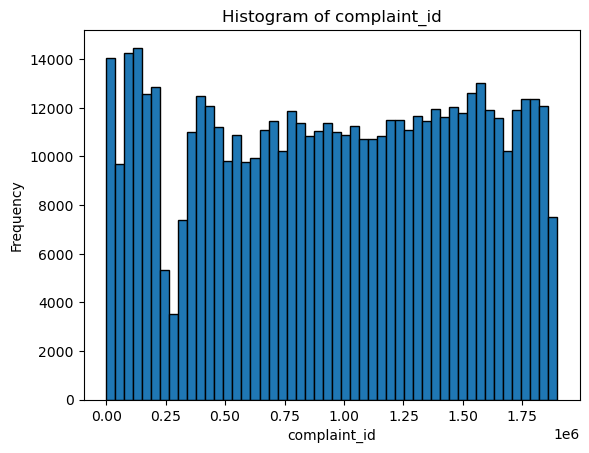

In [6]:
import matplotlib.pyplot as plt

numerical_columns = np.array([i for i in data.columns.tolist() if data[i].dtype != 'object'])
for column in numerical_columns:
    plt.hist(data[column].dropna(), bins=50, edgecolor='k')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

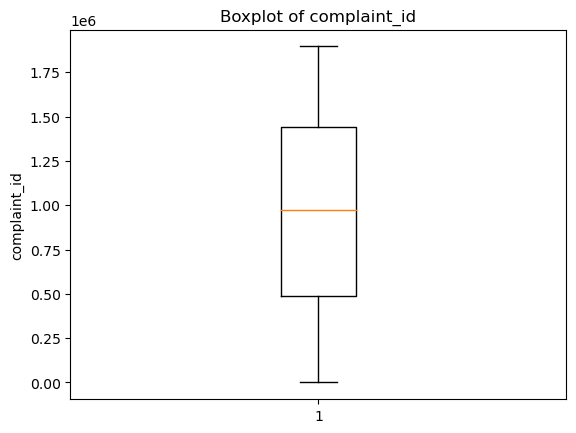

In [7]:
for column in numerical_columns:
    plt.boxplot(data[column].dropna())
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.show()

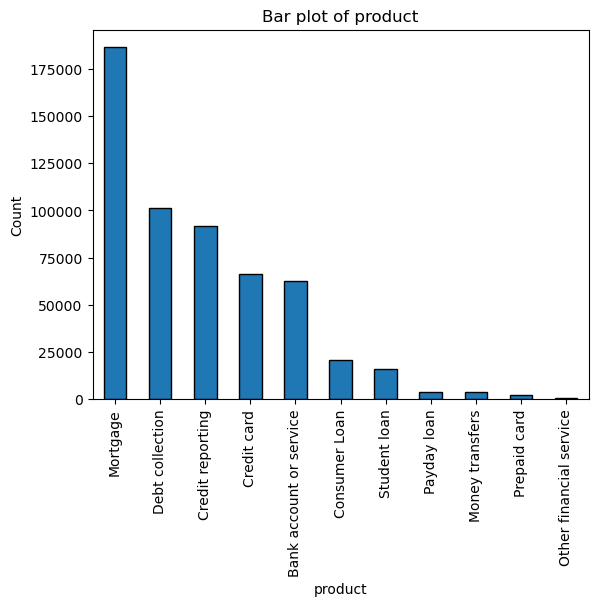

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


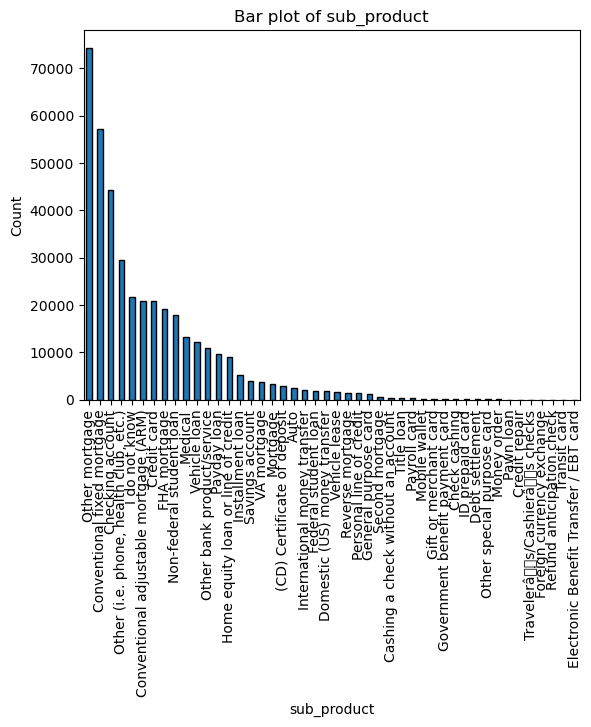

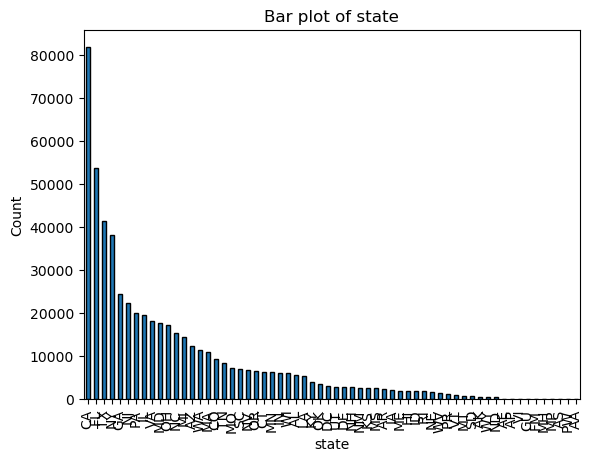

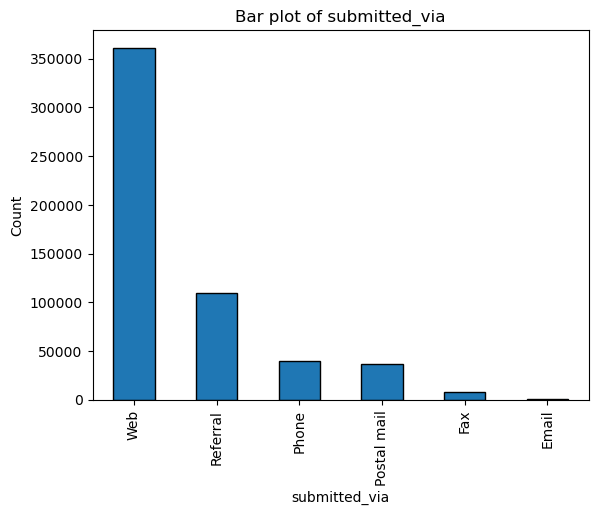

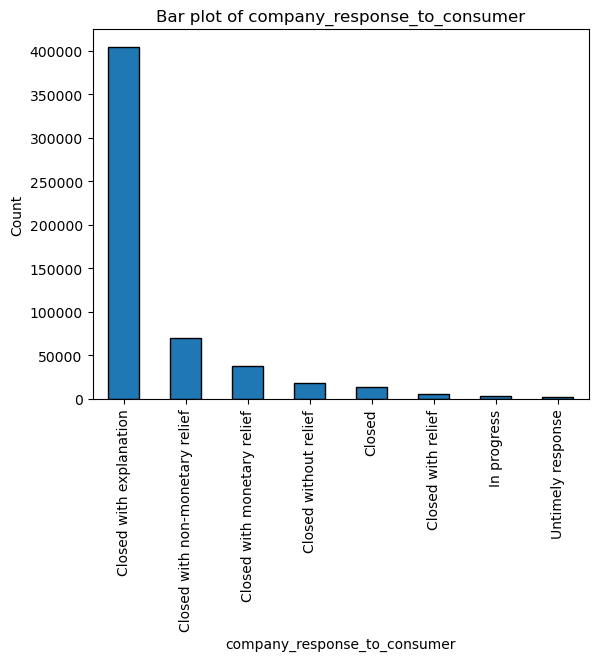

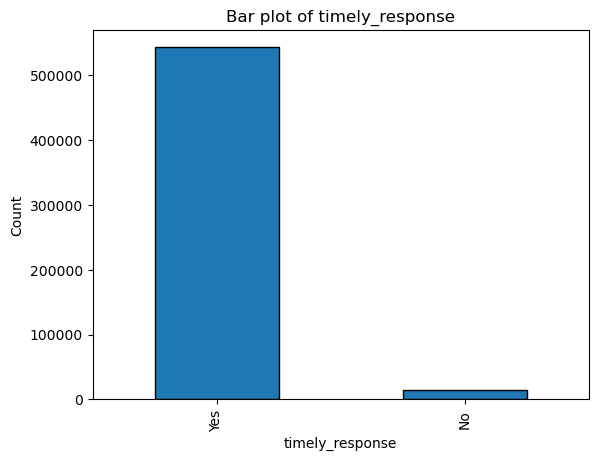

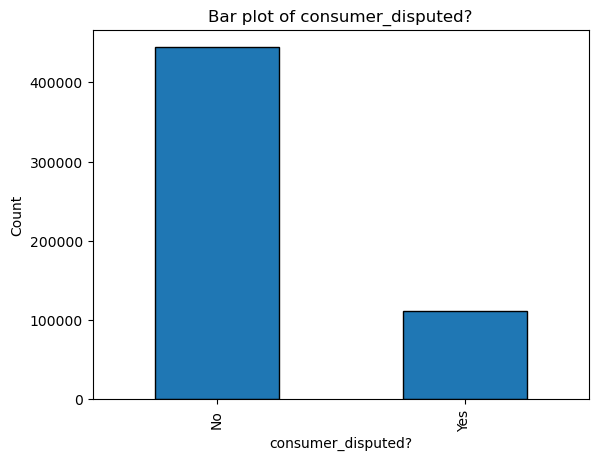

In [8]:
categorical_columns = ['product', 'sub_product',  
                       'state', 'submitted_via', 'company_response_to_consumer', 
                       'timely_response', 'consumer_disputed?']  # List of categorical columns
for column in categorical_columns:
    data[column].value_counts().plot(kind='bar', edgecolor='k')
    plt.title(f'Bar plot of {column}')
    plt.ylabel('Count')
    plt.xlabel(column)
    plt.xticks(rotation=90)
    plt.show()


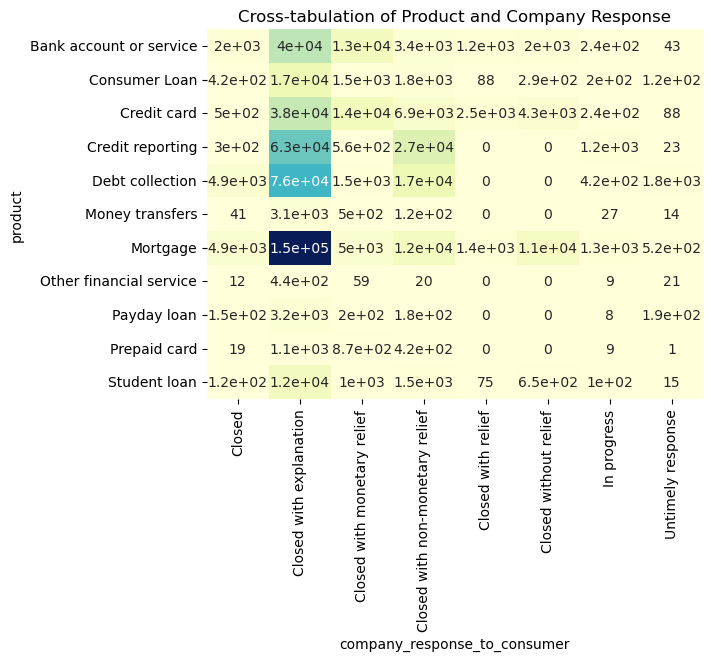

In [9]:
cross_tab = pd.crosstab(data['product'], data['company_response_to_consumer'])
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", cbar=False)
plt.title('Cross-tabulation of Product and Company Response')
plt.show()

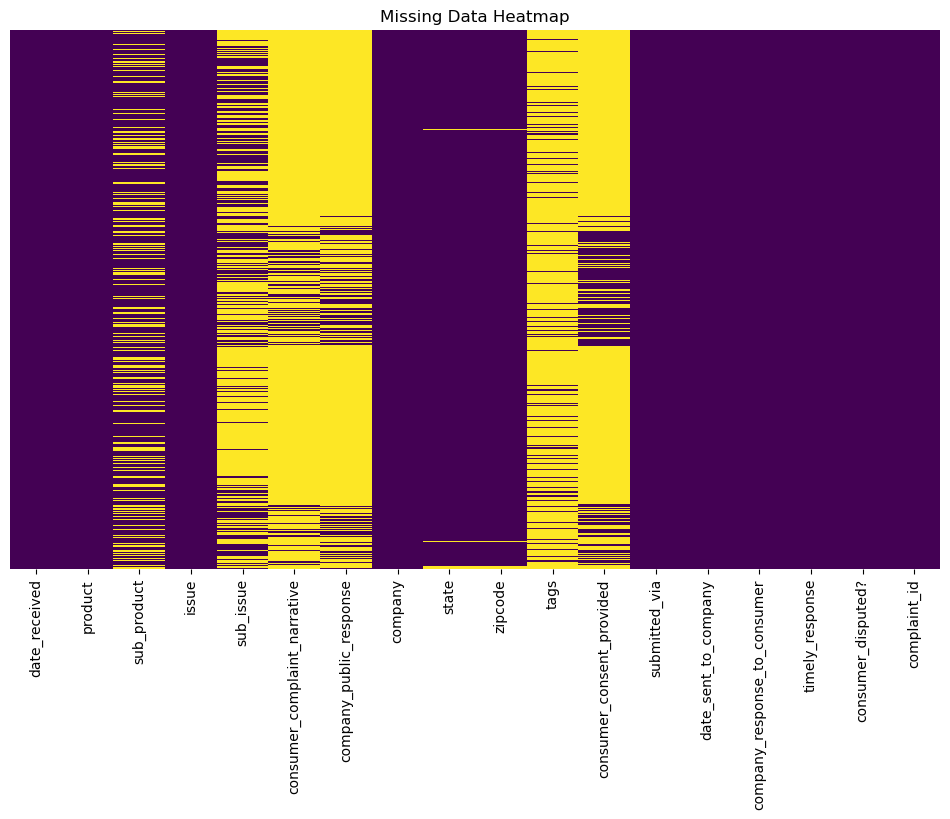

In [10]:
plt.figure(figsize=(12, 7))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Heatmap')
plt.show()


In [11]:
# data = data.dropna(subset=['consumer_complaint_narrative'])
data = data.dropna(subset=['consumer_complaint_narrative'])
print(data.isnull().sum())

date_received                       0
product                             0
sub_product                     20455
issue                               0
sub_issue                       33874
consumer_complaint_narrative        0
company_public_response         34030
company                             0
state                             186
zipcode                           189
tags                            55389
consumer_consent_provided           0
submitted_via                       0
date_sent_to_company                0
company_response_to_consumer        0
timely_response                     0
consumer_disputed?                  0
complaint_id                        0
dtype: int64


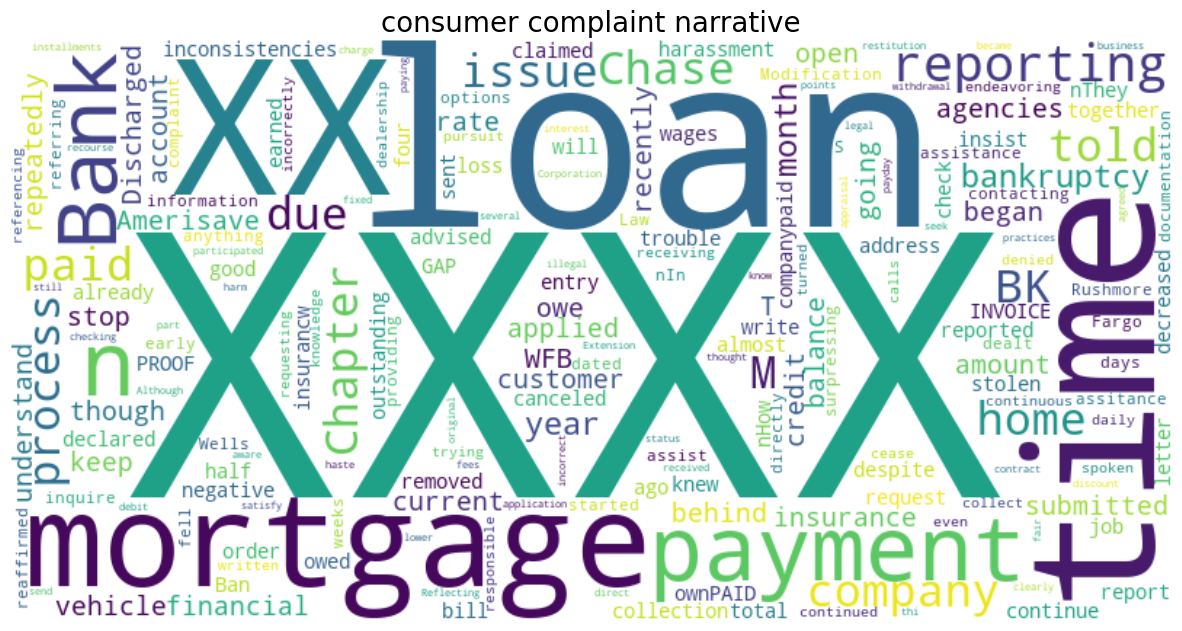

In [12]:
from wordcloud import WordCloud

WordCloud_recommended = WordCloud(width=800, 
                                  height=400,
                                  background_color='white',
                                  collocations=True).generate(str((data['consumer_complaint_narrative'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud_recommended, interpolation='bilinear')
plt.title('consumer complaint narrative', fontsize=20)
plt.axis("off")
plt.show()

In [13]:
data['product'].value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64

In [14]:
data[['consumer_complaint_narrative', 'product']]


,consumer_complaint_narrative,product
190126,XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! \nThey continue to insist I owe them and collection agencies are after me. \nHow can I stop this harassment for a bill I already paid four years ago? \n,Debt collection
190135,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Ban...",Consumer Loan
190155,"In XX/XX/XXXX my wages that I earned at my job decreased by almost half, by XX/XX/XXXX I knew I was in trouble with my home loan. I began contacting WFB whom my home loan is with, for assitance and options. \nIn early XX/XX/XXXX I began the Loan Modification process with Wells Fargo Bank. I was told that they would not assist me with anything financial on my home loan until I fell 90 days behind, though at the time I started to inquire for assistance from WFB I was only a few weeks behind. S...",Mortgage
190207,"I have an open and current mortgage with Chase Bank # XXXX. Chase is reporting the loan payments to XXXX but XXXX is surpressing the information and reporting the loan as Discharged in BK. This mortgage was reaffirmed in a Chapter XXXX BK discharged dated XXXX/XXXX/2013. Chase keeps referring to BK Law for Chapter XXXX and we keep providing documentation for Chapter XXXX, and the account should be open and current with all the payments \n",Mortgage
190208,"XXXX was submitted XX/XX/XXXX. At the time I submitted this complaint, I had dealt with Rushmore Mortgage directly endeavoring to get them to stop the continuous daily calls I was receiving trying to collect on a mortgage for which I was not responsible due to bankruptcy. They denied having knowledge of the bankruptcy, even though I had spoken with them about it repeatedly and had written them repeatedly referencing the bankruptcy requesting them to cease the pursuit, they continued to do so...",Mortgage
...,...,...
553084,"XXXX XXXX is reporting incorrectly, payments have been on time, the vehicle was turned in on time to the dealership. \n",Credit reporting
553085,Reflecting incorrect payment status. Have been on time. \n,Credit reporting
553086,"I have been paying {$180.00} a month through direct debit withdrawal from my checking account for several months on a {$600.00} loan. The {$180.00} a month was an "" Extension '' that I thought was installments to satisfy the original loan. This company has received {$2000.00} in fees on a {$600.00} loan and I still have a balance due. They did send me a contract that I agreed to in haste and did not clearly understand. Although I understand payday loans, how is it fair business to charge thi...",Payday loan
553090,"I recently became aware that Amerisave Mortgage Corporation participated in some illegal practices that harm customers. I did not know at the time ( until recently ) that I had any legal recourse for an issue I had, and I would like to seek restitution at this time. I applied for a 30 year fixed rate mortgage loan with Amerisave on XXXX/XXXX/06 ( loan application # XXXX ). As part of the process I paid for an appraisal. I also paid for "" discount points '' to lower the interest rate on the m...",Mortgage


# model 1 (LogisticRegression)

In [15]:
import re
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    tokens = word_tokenize(text)
    return ' '.join(tokens)

data['processed_text'] = data['consumer_complaint_narrative'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)  
features = vectorizer.fit_transform(data['processed_text'])

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, data['product'], test_size=0.3, random_state=42)

# Initialize and train the model
lr = LogisticRegression()
lr.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [18]:
from sklearn.metrics import classification_report

# Predict on test set
y_pred = lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

Bank account or service       0.78      0.78      0.78      1735
          Consumer Loan       0.73      0.56      0.64      1093
            Credit card       0.79      0.78      0.79      2477
       Credit reporting       0.84      0.84      0.84      3731
        Debt collection       0.80      0.89      0.84      5223
        Money transfers       0.79      0.46      0.58       206
               Mortgage       0.91      0.95      0.93      4442
Other financial service       0.00      0.00      0.00        31
            Payday loan       0.53      0.16      0.24       221
           Prepaid card       0.81      0.54      0.65       244
           Student loan       0.86      0.76      0.81       639

               accuracy                           0.83     20042
              macro avg       0.71      0.61      0.64     20042
           weighted avg       0.82      0.83      0.82     20042



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
def predict_product(complaint_text):
    processed = preprocess_text(complaint_text)
    features = vectorizer.transform([processed])
    return model.predict(features)[0]

# Example prediction
example_complaint = "I have an issue with my credit card billing"
predicted_product = predict_product(example_complaint)
print(predicted_product)


Credit card


In [20]:
example_complaint = "My procedures for the private loan have not been completed"
predicted_product = predict_product(example_complaint)
print(predicted_product)

Student loan


# model 2 (LSTM)

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
tokenizer = Tokenizer(num_words=5000)  # Adjust num_words as needed
tokenizer.fit_on_texts(data['processed_text'])
sequences = tokenizer.texts_to_sequences(data['processed_text'])

# Padding
max_seq_length = 200  # Adjust the sequence length as needed
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)


In [22]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(data['product'])
categorical_labels = to_categorical(encoded_labels, num_classes=11) # 11 for the number of products

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from tensorflow.keras.layers import GRU, Conv1D, MaxPooling1D

# Adjust model structure - example using GRU
model = Sequential()
model.add(Embedding(input_dim=3000, output_dim=128, input_length=max_seq_length))  # Reduced vocabulary size
model.add(Conv1D(64, 5, activation='relu'))  # Added CNN layer
model.add(MaxPooling1D(pool_size=4))
model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))  # Switched to GRU with fewer units
model.add(Dense(11, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          384000    
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 64)           0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 11)                715       
                                                                 
Total params: 450,699
Trainable params: 450,699
Non-trainable params: 0
__________________________________________________

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, categorical_labels, test_size=0.3, random_state=42)

history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
731/731 [==============================] - 181s 234ms/step - loss: 1.0197 - accuracy: 0.6628 - val_loss: 0.6850 - val_accuracy: 0.7813
Epoch 2/10
731/731 [==============================] - 132s 180ms/step - loss: 0.5904 - accuracy: 0.8161 - val_loss: 0.5782 - val_accuracy: 0.8192
Epoch 3/10
731/731 [==============================] - 128s 175ms/step - loss: 0.4948 - accuracy: 0.8473 - val_loss: 0.5451 - val_accuracy: 0.8313
Epoch 4/10
731/731 [==============================] - 125s 172ms/step - loss: 0.4318 - accuracy: 0.8667 - val_loss: 0.5432 - val_accuracy: 0.8322
Epoch 5/10
731/731 [==============================] - 126s 172ms/step - loss: 0.3831 - accuracy: 0.8803 - val_loss: 0.5506 - val_accuracy: 0.8352
Epoch 6/10
731/731 [==============================] - 125s 171ms/step - loss: 0.3395 - accuracy: 0.8946 - val_loss: 0.5797 - val_accuracy: 0.8300
Epoch 7/10
731/731 [==============================] - 123s 168ms/step - loss: 0.2965 - accuracy: 0.9084 - val_loss: 0.6023 -

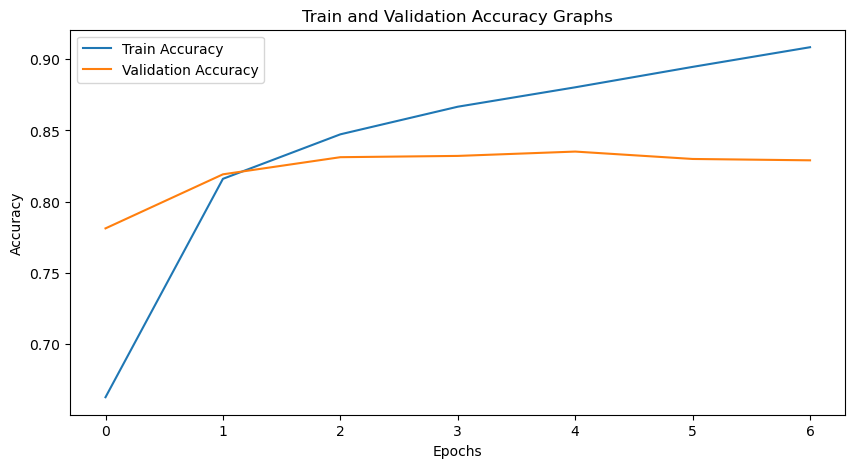

In [25]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy Graphs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

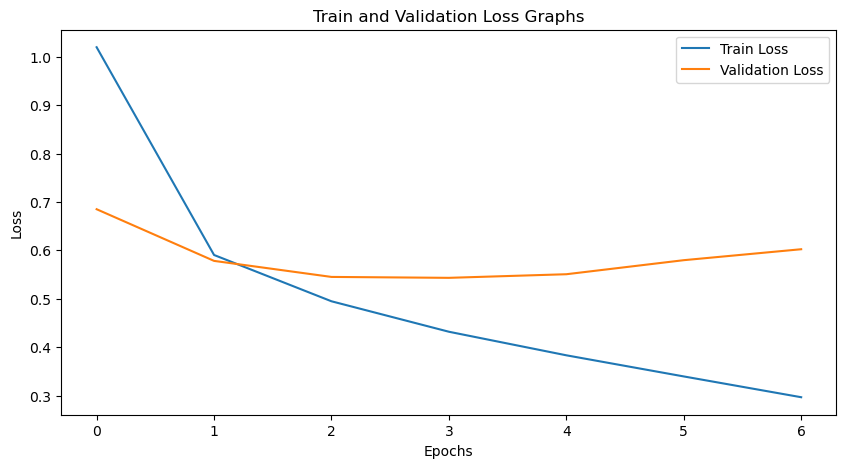

In [26]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss Graphs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
y_pred_labels = np.argmax(y_pred, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

print(classification_report(y_test_labels, y_pred_labels, target_names=encoder.classes_))

In [ ]:
def predict_product(complaint_text):
    processed = preprocess_text(complaint_text)
    sequence = tokenizer.texts_to_sequences([processed])
    padded = pad_sequences(sequence, maxlen=max_seq_length)
    prediction = model.predict(padded)
    predicted_label = np.argmax(prediction, axis=1)
    return encoder.inverse_transform(predicted_label)[0]

# Example prediction
example_complaint = "I have an issue with my credit card billing."
predicted_product = predict_product(example_complaint)
print(predicted_product)


# Sentiment Intensity Analyzer

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

data['sentiment'] = data['consumer_complaint_narrative'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [ ]:
def categorize_sentiment(score):
    if score < -0.05:
        return 'negative'
    elif score > 0.05:
        return 'positive'
    else:
        return 'neutral'

data['sentiment_category'] = data['sentiment'].apply(categorize_sentiment)

In [ ]:
sentiment_counts = data['sentiment_category'].value_counts()
print(sentiment_counts)


In [ ]:
data.to_csv('consumer_complaints_sentiment.csv', index=False)

In [ ]:
sample_for_review = data.sample(n=50, random_state=42)  

In [ ]:
# data.dropna(inplace=True)
# data['zipcode'].fillna(data['zipcode'].mode()[0], inplace=True)
# data['state'].fillna(data['state'].mode()[0], inplace=True)

# data['sub_product'].fillna('Not Specified', inplace=True)

# data['sub_issue'].fillna('Not Specified', inplace=True)

# data['consumer_consent_provided'].fillna('Not Provided', inplace=True)

# data['company_public_response'].fillna('No Response', inplace=True)

# data['tags'].fillna('No Tags', inplace=True)

# data['consumer_complaint_narrative'].fillna('No Narrative Provided', inplace=True)
# data = data.dropna(subset=['consumer_complaint_narrative'])
# print(data.isnull().sum())

In [ ]:
# data.dropna(inplace=True)

In [ ]:
pd.set_option('max_colwidth', 1000)
data[['consumer_complaint_narrative']].head(5)